## Forecasting Ekspor Indonesia

Proyek ini bertujuan membangun **model time series** untuk memproyeksikan nilai **ekspor Indonesia 12 bulan ke depan**.

- **Model**: SARIMA menggunakan `SARIMAX` dari `statsmodels`
- **Sumber data**: BPS (Badan Pusat Statistik), disimpan di PostgreSQL
- **Periode data**: Januari 2018 – September 2025, frekuensi bulanan

Hasil forecasting diharapkan dapat memberikan **gambaran kuantitatif** bagi pelaku ekspor dan pengambil keputusan mengenai **potensi ekspor Indonesia pada tahun 2026**, lengkap dengan **ukuruan akurasi model** dan **interval ketidakpastian**.

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import psycopg2

conn = psycopg2.connect(
    host="******",
    database="*******",
    user="********",
    password="********"
)

cur = conn.cursor()

print("Connected to PostgreSQL")

cur.execute("SELECT * FROM forecast_export2.forcast_ekspor;")
rows = cur.fetchall()

colnames = [desc[0] for desc in cur.description]

df = pd.DataFrame(rows, columns=colnames)

cur.close()
conn.close()

Connected to PostgreSQL


In [2]:
df.info()
df.isnull().sum()
df.head()



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 93 entries, 0 to 92
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   month   93 non-null     object
 1   value   93 non-null     object
dtypes: object(2)
memory usage: 1.6+ KB


,month,value
0,2018-01-01,13233.6
1,2018-02-01,12743.6
2,2018-03-01,14254.5
3,2018-04-01,13317.4
4,2018-05-01,14565.2


In [3]:
series = df.copy()

# rubah type data to_datetime
series["month"] = pd.to_datetime(series["month"])
series = series.set_index("month")

# float
series["value"] = series["value"].astype(float)

series = series.asfreq("MS")

print(series.index.freq)
print(series.info())
print(series.head())

<MonthBegin>
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 93 entries, 2018-01-01 to 2025-09-01
Freq: MS
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   value   93 non-null     float64
dtypes: float64(1)
memory usage: 1.5 KB
None
              value
month              
2018-01-01  13233.6
2018-02-01  12743.6
2018-03-01  14254.5
2018-04-01  13317.4
2018-05-01  14565.2


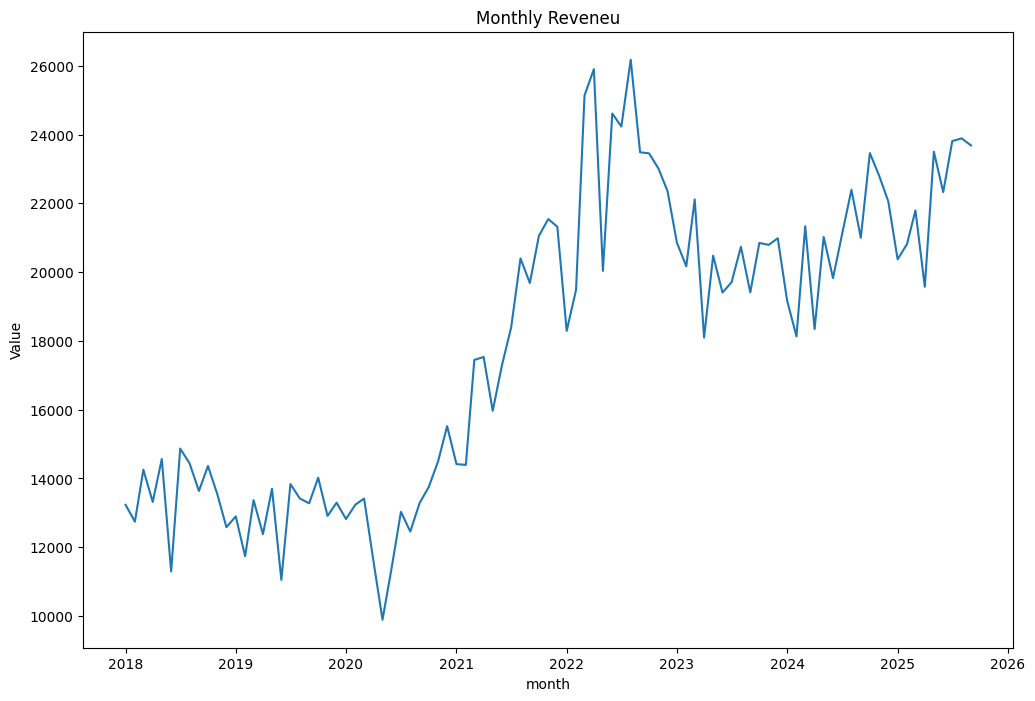

In [4]:
plt.figure(figsize=(12,8))
plt.plot(series)
plt.title("Monthly Reveneu")
plt.xlabel("month")
plt.ylabel("Value")
plt.show()

## Train–Test Split

Pada tahap ini, deret waktu dibagi menjadi dua bagian agar performa model bisa dievaluasi secara **out-of-sample**:

- **Train set (~88%)**: digunakan untuk melatih model SARIMA
- **Test set (~12% terakhir / 12 bulan)**: digunakan untuk mengevaluasi kemampuan model melakukan prediksi ke depan

Pembagian dilakukan **tanpa mengacak urutan waktu**, sehingga struktur time series tetap terjaga (tidak ada data leakage dari masa depan ke masa lalu).

In [5]:
split_point = int(len(series) * 0.88)

train = series.iloc[:split_point]
test = series.iloc[split_point:]

print(train.shape, test.shape)


(81, 1) (12, 1)


<Figure size 1200x800 with 0 Axes>

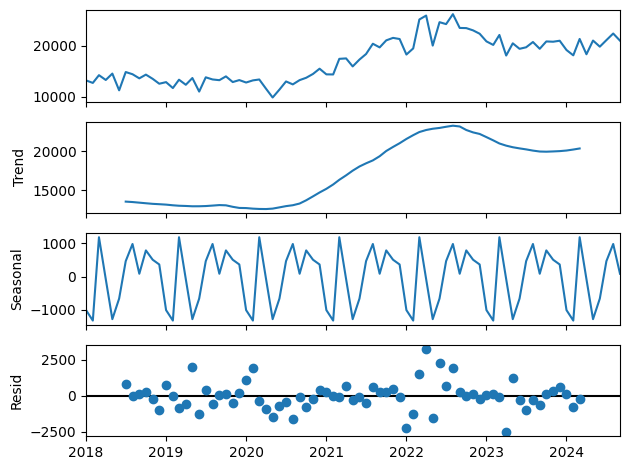

In [6]:
from statsmodels.tsa.seasonal import seasonal_decompose

decomposition = seasonal_decompose(train, model="additive", period=12)

plt.figure(figsize=(12,8))
decomposition.plot()
plt.tight_layout()
plt.show()

In [7]:
from statsmodels.tsa.stattools import adfuller, kpss

result_adf = adfuller(train)
print("ADF-Statistic:", result_adf[0])
print("p-value:", result_adf[1])

result_kpss = kpss(train, regression="ct", nlags="auto")
print("kpss-Statistic:", result_kpss[0])
print("p-value:", result_kpss[1])


ADF-Statistic: -1.1354324418090873
p-value: 0.7007370754060092
kpss-Statistic: 0.156675567416326
p-value: 0.04110369381972834


## Uji Stasioneritas: ADF & KPSS

Sebelum membangun model SARIMA, deret waktu perlu dicek **stasioneritasnya**. Di sini digunakan dua uji statistik:

- **ADF (Augmented Dickey–Fuller)**: hipotesis nol = data **memiliki unit root** (tidak stasioner)
- **KPSS**: hipotesis nol = data **stasioner terhadap tren**

Kombinasi kedua uji ini membantu menentukan kebutuhan **differencing non-musiman (`d`)** dan **differencing musiman (`D`)**.

In [8]:
df_diff = train.diff().dropna()

result_adf = adfuller(df_diff)
print("ADF-Statistic:", result_adf[0])
print("p-value:", result_adf[1])

result_kpss = kpss(df_diff, regression="ct", nlags="auto")
print("kpss-Statistic:", result_kpss[0])
print("p-value:", result_kpss[1])

len(df_diff)

ADF-Statistic: -3.3752821754378894
p-value: 0.011830921040518224
kpss-Statistic: 0.10012877179521021
p-value: 0.1


C:\Users\etvit\AppData\Local\Temp\ipykernel_21744\2023071343.py:7: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  result_kpss = kpss(df_diff, regression="ct", nlags="auto")


80

Berdasarkan hasil ADF dan KPSS setelah dilakukan differencing satu kali, deret waktu menjadi **stasioner**. Dari sini diambil keputusan awal:

- **d = 1** (satu kali differencing non-musiman)
- **D = 0** (belum dilakukan seasonal differencing pada tahap ini)

Nilai ini kemudian menjadi dasar awal dalam pencarian model SARIMA yang lebih optimal.

<Figure size 1200x800 with 0 Axes>

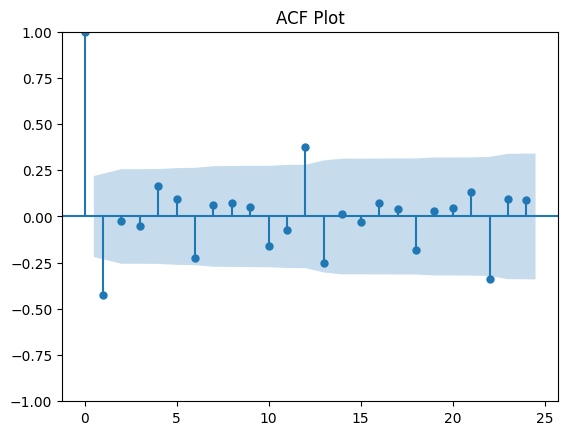

<Figure size 1200x800 with 0 Axes>

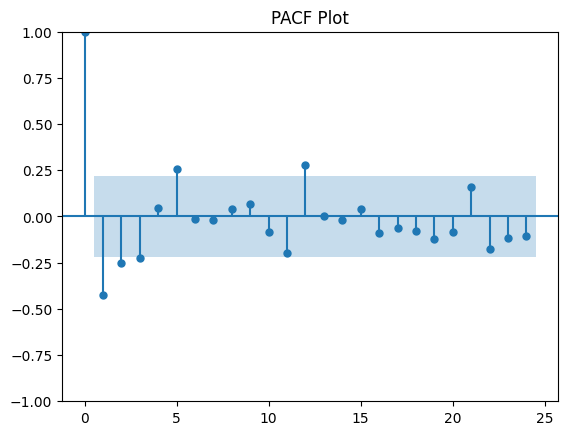

In [9]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plt.figure(figsize=(12,8))
plot_acf(df_diff, lags=24)
plt.title("ACF Plot")
plt.show()

plt.figure(figsize=(12,8))
plot_pacf(df_diff,lags=24)
plt.title("PACF Plot")
plt.show()


## Menambahkan Variabel Eksogen (Dummy COVID)

Untuk menguji apakah periode pandemi COVID-19 memiliki pengaruh yang **tidak tertangkap hanya oleh pola tren dan musiman**, dibuat sebuah variabel eksogen:

- `covid_dummy = 1` untuk periode 2020-01 s.d. 2022-12
- `covid_dummy = 0` untuk periode lainnya

Variabel ini kemudian digunakan sebagai input tambahan (`exogenous`) pada model SARIMAX dan dibandingkan dengan model tanpa eksogen.


In [10]:
series["covid_dummy"] = 0 
series["2020-01-01 : 2022-12-01", "covid_dummy"] = 1

train_size = int(len(series) * 0.88)

y_train = series["value"][:train_size]
y_test = series["value"][train_size:]

x_train = series["covid_dummy"][:train_size]
x_test = series["covid_dummy"][train_size:]

print(f"y_train: {y_train.shape}, y_test: {y_test.shape}")
print(f"y_train: {x_train.shape}, y_test: {x_test.shape}")
print(y_train.head())
print(x_train.head())


y_train: (81,), y_test: (12,)
y_train: (81,), y_test: (12,)
month
2018-01-01    13233.6
2018-02-01    12743.6
2018-03-01    14254.5
2018-04-01    13317.4
2018-05-01    14565.2
Freq: MS, Name: value, dtype: float64
month
2018-01-01    0
2018-02-01    0
2018-03-01    0
2018-04-01    0
2018-05-01    0
Freq: MS, Name: covid_dummy, dtype: int64


In [11]:
from pmdarima import auto_arima

# model menggunakan exogenous
model = auto_arima(
    y_train,
    exogenous=x_train,
    seasonal=True,
    m=12,
    trace=True,
    error_action='ignore',
    suppress_warnings=True
)

print(model.summary())

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,0,1)[12] intercept   : AIC=1422.592, Time=0.53 sec
 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=1434.678, Time=0.02 sec
 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=1417.675, Time=0.09 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=1416.143, Time=0.07 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=1432.905, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[12] intercept   : AIC=1421.355, Time=0.05 sec
 ARIMA(0,1,1)(1,0,1)[12] intercept   : AIC=1418.142, Time=0.17 sec
 ARIMA(0,1,1)(0,0,2)[12] intercept   : AIC=1417.983, Time=0.23 sec
 ARIMA(0,1,1)(1,0,0)[12] intercept   : AIC=1415.491, Time=0.21 sec
 ARIMA(0,1,1)(2,0,0)[12] intercept   : AIC=1417.452, Time=0.45 sec
 ARIMA(0,1,1)(2,0,1)[12] intercept   : AIC=inf, Time=0.93 sec
 ARIMA(0,1,0)(1,0,0)[12] intercept   : AIC=1427.470, Time=0.06 sec
 ARIMA(1,1,1)(1,0,0)[12] intercept   : AIC=1418.626, Time=0.11 sec
 ARIMA(0,1,2)(1,0,0)[12] intercept   : AIC=1417.473, Time=0.25 sec
 ARIMA(1,1,2)(1,0,0)[12]

In [12]:
model2 = auto_arima(
    y_train,
    seasonal=True,
    m=12,
    trace=True,
    error_action='ignore',
    suppress_warnings=True
)

print(model2.summary())

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,0,1)[12] intercept   : AIC=1422.592, Time=0.55 sec
 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=1434.678, Time=0.02 sec
 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=1417.675, Time=0.09 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=1416.143, Time=0.13 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=1432.905, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[12] intercept   : AIC=1421.355, Time=0.07 sec
 ARIMA(0,1,1)(1,0,1)[12] intercept   : AIC=1418.142, Time=0.15 sec
 ARIMA(0,1,1)(0,0,2)[12] intercept   : AIC=1417.983, Time=0.24 sec
 ARIMA(0,1,1)(1,0,0)[12] intercept   : AIC=1415.491, Time=0.20 sec
 ARIMA(0,1,1)(2,0,0)[12] intercept   : AIC=1417.452, Time=0.42 sec
 ARIMA(0,1,1)(2,0,1)[12] intercept   : AIC=inf, Time=0.99 sec
 ARIMA(0,1,0)(1,0,0)[12] intercept   : AIC=1427.470, Time=0.06 sec
 ARIMA(1,1,1)(1,0,0)[12] intercept   : AIC=1418.626, Time=0.12 sec
 ARIMA(0,1,2)(1,0,0)[12] intercept   : AIC=1417.473, Time=0.25 sec
 ARIMA(1,1,2)(1,0,0)[12]

## Pemilihan Awal Model dengan `auto_arima`

Fungsi `auto_arima` digunakan untuk melakukan pencarian otomatis kombinasi orde SARIMA berdasarkan kriteria **AIC (Akaike Information Criterion)**.

- Model terbaik yang direkomendasikan `auto_arima` pada tahap ini adalah **SARIMA(0,1,1)(1,0,0)[12]** dengan **AIC ≈ 1414.36**.
- Hasil ini menjadi **titik awal** dalam eksplorasi model, sebelum akhirnya dicoba beberapa spesifikasi lain yang memberikan AIC dan diagnostik residual yang lebih baik.

## Membandingkan Model dengan dan tanpa Eksogen

Pada tahap ini dua jenis model dibandingkan:

- **Model tanpa eksogen**: hanya memanfaatkan pola internal deret waktu (tren, musiman, dan siklus)
- **Model dengan eksogen (dummy COVID)**: menambahkan variabel `covid_dummy` sebagai penjelas tambahan

Perbandingan dilakukan menggunakan **AIC** dan signifikansi koefisien eksogen. Hasilnya menunjukkan bahwa:

- AIC **lebih baik pada model tanpa eksogen**
- Koefisien `covid_dummy` tidak signifikan secara statistik (p-value tinggi)

Sehingga, model **tanpa eksogen** dipilih sebagai pendekatan yang lebih sederhana namun tetap kuat secara statistik.

In [13]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

# tanpa exog

mod_no = SARIMAX(y_train, order=(0,1,1), seasonal_order=(1,0,0,12)).fit(disp=False)
print('AIC no exog:', mod_no.aic)

mod_exog = SARIMAX(y_train, exog=x_train, order=(0,1,1), seasonal_order=(1,0,0,12)).fit(disp=False)
print("AIC with exog:",mod_exog.aic)

print(mod_exog.summary())
print('params pvalues for exog:')
print(mod_exog.params.filter(like='exog'), mod_exog.pvalues.filter(like='exog'))

AIC no exog: 1414.363434763945
AIC with exog: 1416.363434763945
                                      SARIMAX Results                                      
Dep. Variable:                               value   No. Observations:                   81
Model:             SARIMAX(0, 1, 1)x(1, 0, [], 12)   Log Likelihood                -704.182
Date:                             Tue, 02 Dec 2025   AIC                           1416.363
Time:                                     22:40:08   BIC                           1425.892
Sample:                                 01-01-2018   HQIC                          1420.184
                                      - 09-01-2024                                         
Covariance Type:                               opg                                         
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
covid_dummy          0   2.35e+05       

## Interpretasi Variabel COVID

Hasil pemodelan tidak berarti bahwa **pandemi COVID-19 tidak berpengaruh terhadap ekspor**, melainkan:

- Dampak pandemi **tidak dapat ditangkap dengan baik hanya oleh satu dummy sederhana** (`0/1`)
- Kenaikan ekspor pada periode tersebut lebih banyak dijelaskan oleh kombinasi **tren jangka panjang, pola musiman, dan faktor global lain**

Dengan demikian, memasukkan dummy COVID justru **tidak menambah daya jelaskan model**, sehingga secara sadar diputuskan untuk **tidak menggunakan variabel eksogen** dalam model final.

In [14]:
model_final = SARIMAX(
    y_train,
    order=(0,1,1),
    seasonal_order=(0,1,1,12),
    enforce_stationarity=False,
    enforce_invertibility=False,
).fit()

print(model_final.summary())

                                     SARIMAX Results                                      
Dep. Variable:                              value   No. Observations:                   81
Model:             SARIMAX(0, 1, 1)x(0, 1, 1, 12)   Log Likelihood                -482.557
Date:                            Tue, 02 Dec 2025   AIC                            971.114
Time:                                    22:40:08   BIC                            977.080
Sample:                                01-01-2018   HQIC                           973.415
                                     - 09-01-2024                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.4395      0.095     -4.628      0.000      -0.626      -0.253
ma.S.L12      -0.5613      0.106   

## Pemilihan Model Final SARIMA

Setelah mencoba beberapa spesifikasi model, termasuk rekomendasi dari `auto_arima`, model terbaik dipilih berdasarkan **AIC** dan **diagnostik residual**.

- **Model final**: `SARIMA(0,1,1)(0,1,1,12)`
- **AIC**: ≈ 971.11 (jauh lebih rendah dibanding model awal)
- Residual telah memenuhi asumsi **white noise** (tidak ada autokorelasi yang tersisa dan mendekati distribusi normal)

Model ini kemudian digunakan untuk evaluasi performa (MAPE/RMSE) dan melakukan forecasting 12 bulan ke depan.

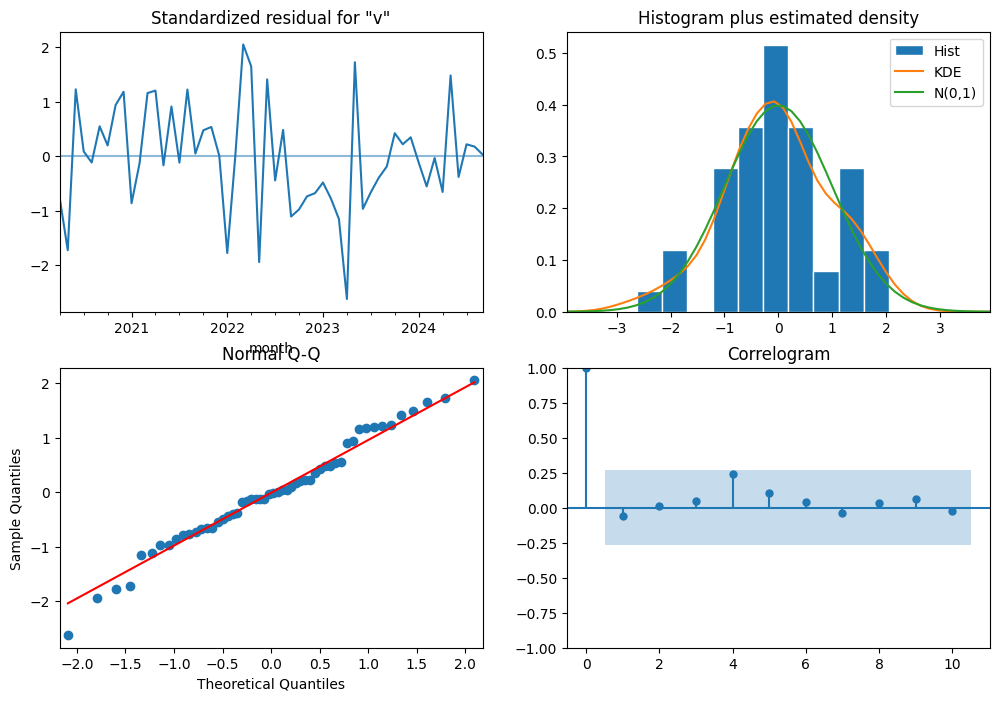

In [15]:
model_final.plot_diagnostics(figsize=(12,8))
plt.show()

## Evaluasi Akurasi Model: MAPE dan RMSE

Untuk mengukur seberapa baik model memprediksi data yang **tidak digunakan saat training**, dilakukan backtest pada **12 bulan terakhir (test set)**.

Dua metrik utama yang digunakan:

- **MAPE (Mean Absolute Percentage Error)**: rata-rata persentase kesalahan prediksi terhadap nilai aktual
- **RMSE (Root Mean Squared Error)**: mengukur besar kesalahan dalam satuan yang sama dengan data

Nilai MAPE sekitar **5%** menunjukkan bahwa model tergolong **akurat untuk konteks data ekonomi/makro**, sementara nilai RMSE memberikan gambaran seberapa besar deviasi absolut rata-rata dalam satuan nilai ekspor.

In [16]:
forecast_test = model_final.forecast(steps=len(y_test))

from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

mape = np.mean(np.abs((y_test - forecast_test) / y_test)) * 100 
rmse = np.sqrt(mean_squared_error(y_test, forecast_test))

print("MAPE:", mape)
print("RMSE:", rmse)

MAPE: 5.1598063099786655
RMSE: 1330.672511031864


## FORECAST 12 BULAN

C:\Users\etvit\AppData\Local\Temp\ipykernel_21744\1740407424.py:19: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  future_index = pd.date_range(start=series.index[-1] + pd.offsets.MonthEnd(1),


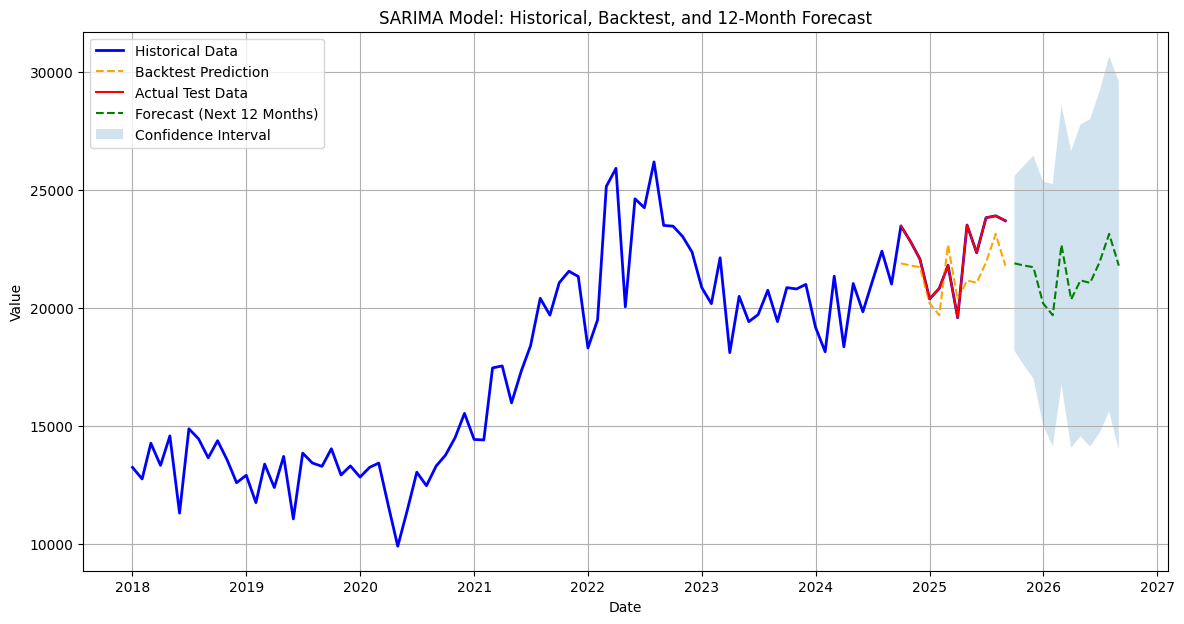

In [17]:
series = series.iloc[:, :1]   # ambil hanya kolom pertama 'value'



plt.figure(figsize=(14,7))

# 1. Plot historical sekali saja
plt.plot(series, label="Historical Data", linewidth=2, color='blue')

# 2. Backtest (pastikan index align)
test_forecast = model_final.predict(start=y_test.index[0], end=y_test.index[-1])
test_forecast.index = y_test.index
plt.plot(test_forecast, label="Backtest Prediction", linestyle='--', color='orange')

# 3. Plot actual test
plt.plot(y_test, label="Actual Test Data", color='red')

# 4. Future forecast
future_index = pd.date_range(start=series.index[-1] + pd.offsets.MonthEnd(1),
                             periods=12, freq='M')

future_forecast = model_final.get_forecast(steps=12)
forecast_mean = future_forecast.predicted_mean
forecast_ci = future_forecast.conf_int()

forecast_mean.index = future_index
forecast_ci.index = future_index

plt.plot(forecast_mean, label="Forecast (Next 12 Months)", linestyle='--', color='green')

plt.fill_between(forecast_ci.index,
                 forecast_ci.iloc[:,0],
                 forecast_ci.iloc[:,1],
                 alpha=0.2,
                 label="Confidence Interval")

plt.title("SARIMA Model: Historical, Backtest, and 12-Month Forecast")
plt.xlabel("Date")
plt.ylabel("Value")
plt.legend()
plt.grid(True)

plt.show()


In [18]:
# DataFrame hasil forecast 12 bulan ke depan (mean + confidence interval)

forecast_final = pd.DataFrame(
    {
        "forecast": forecast_mean,
        "lower_ci": forecast_ci.iloc[:, 0],
        "upper_ci": forecast_ci.iloc[:, 1],
    }
)

print(forecast_final)
print(series.tail())


                forecast      lower_ci      upper_ci
2025-09-30  21878.277227  18179.116662  25577.437792
2025-10-31  21787.425770  17546.682701  26028.168839
2025-11-30  21714.989908  16994.421586  26435.558229
2025-12-31  20187.333526  15031.429926  25343.237126
2026-01-31  19680.485488  14123.259868  25237.711109
2026-02-28  22660.307675  16728.947292  28591.668059
2026-03-31  20349.235508  14065.971609  26632.499407
2026-04-30  21154.254324  14537.775170  27770.733478
2026-05-31  21052.134813  14118.434587  27985.835038
2026-06-30  21921.340183  14684.308269  29158.372096
2026-07-31  23127.416450  15599.256805  30655.576095
2026-08-31  21780.715218  13972.239979  29589.190456
              value
month              
2025-05-01  23502.8
2025-06-01  22326.5
2025-07-01  23811.6
2025-08-01  23890.5
2025-09-01  23684.9
